In [322]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import yaml

import panda2.panda2 as panda2
import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan

datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters'


def get_en_comp0(fraw, npix=1):
    with tb.open_file(fraw) as f:
        #print(f)
        #print(dir(f.root.meta_data))
        comp1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp1_before')))
        arg = np.argwhere(comp1==1)#ivan was 1
        if len(arg)!=npix:
            print('ERROR!!!!!', fraw)
        if npix==1:
            return arg[0]
        else:
            return arg
        
def get_conf(fraw, conf_name='IPDAC'):
    with tb.open_file(fraw) as f:
        conf = yaml.unsafe_load(f.root.meta_data.get_attr('firmware_before'))
        if conf_name in ['VDACBL']:
            return int(conf['CONF'][conf_name], 2)
        else:
            return int(conf['CONF'][conf_name][::-1], 2)

def plot_data(list_fraw):
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), ('IPDAC', 'i')])
    for i, fraw in enumerate(list_fraw):
        fname = os.path.basename(fraw)
        fhit = fraw[:-7] + 'hit.h5'
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]
        col, row = get_en_comp0(fraw)
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow
        #dat1 = dat[dat['comp']==0] #### fast   ##hui
        if len(dat1)!=0:
        #print(dat1)
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
            
            fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
            x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            plt.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i))
            plt.plot(param['inj'], nhit1, 'C{}.'.format(i), label=label)
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            ret[i]['th_err']=fit[1+3]
            ret[i]['col']=col
            ret[i]['row']=row
            ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')


    ## show x-axis and y-axis and legend
    plt.xlim(0,0.2)
    plt.xlabel('Injection[V]')
    plt.ylabel('#')
    plt.legend()
    return ret

def plot_data_png(list_fraw):
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), 
                            #('IPDAC', 'i')
                           ])
    ## prepare for plot
    fig,ax = plt.subplots()
    outdir = os.path.join(os.path.dirname(list_fraw[0]),"img")
    isExist = os.path.exists(outdir)
    if not isExist:
       os.makedirs(outdir)

    for i, fraw in enumerate(list_fraw):
        fname = os.path.basename(fraw)
        fhit = fraw[:-7] + 'hit.h5'
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]
        col, row = get_en_comp0(fraw)
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow
        #dat1 = dat[dat['comp']==0] #### fast   ##hui
        if len(dat1)!=0:
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
            
            fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
            x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            ax.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i))
            ax.plot(param['inj'], nhit1, 'C{}.'.format(i), label=label)
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            ret[i]['th_err']=fit[1+3]
            ret[i]['col']=col
            ret[i]['row']=row
            #ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')

    ## saving plot
    ax.set_xlim(0,0.2)
    ax.set_xlabel('Injection[V]')
    ax.set_ylabel('#')
    ax.legend()
    ax.set_title('{}-{}'.format(col,row))
    fig.savefig(os.path.join(outdir,'{}-{}.png'.format(col,row)))
    plt.close()
    return ret


In [162]:
#int(conf['CONF']['VDACBL'],2)

In [177]:
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)

20240515_144759_injection_scan.h5
20240515_144806_injection_scan.h5
20240515_144813_injection_scan.h5
20240515_144820_injection_scan.h5
20240515_144827_injection_scan.h5
20240515_144834_injection_scan.h5
20240515_144841_injection_scan.h5
20240515_144848_injection_scan.h5
20240515_144855_injection_scan.h5


## scurves of TDAC 0 to 7 of PIX[15,32]

array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_123600_injection_scan.h5', 0.10051628, 5.3824966e-05, 15, 32),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_123440_injection_scan.h5', 0.11489234, 2.7958895e-05, 15, 32)],
      dtype=[('fname', 'S128'), ('th', '<f4'), ('th_err', '<f4'), ('col', '<i4'), ('row', '<i4')])

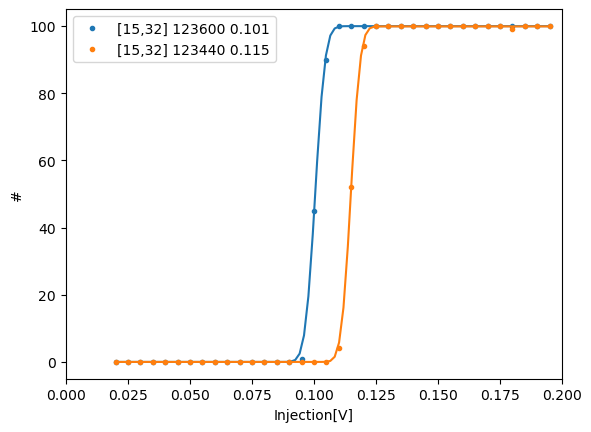

In [70]:
####################
###### IPDAC=8
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters'
list_fraw = []
list_fraw.append(os.path.join(datdir, '20240508_123600_injection_scan.h5'))  #TDAC=0
#list_fraw.append(os.path.join(datdir, '20240508_122249_injection_scan.h5'))  #TDAC=1
#list_fraw.append(os.path.join(datdir, '20240508_122007_injection_scan.h5'))  #TDAC=3
list_fraw.append(os.path.join(datdir, '20240508_123440_injection_scan.h5'))  #TDAC=7
plot_data(list_fraw)

ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155620_injection_scan.h5


array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155620_injection_scan.h5', 0.05707717, 1.9476789e-05, 0, 0, 16)],
      dtype=[('fname', 'S128'), ('th', '<f4'), ('th_err', '<f4'), ('col', '<i4'), ('row', '<i4'), ('IPDAC', '<i4')])

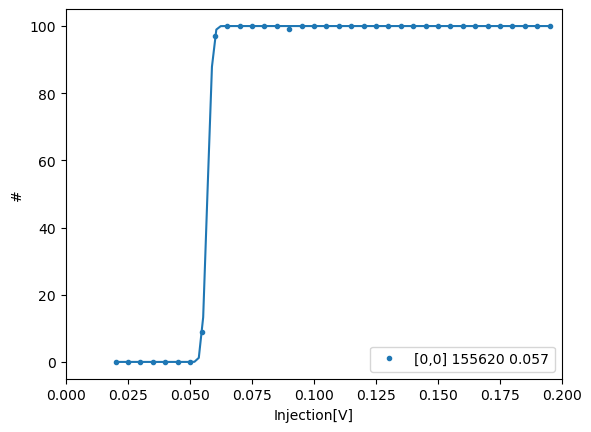

In [203]:
####################
###### IPDAC=8
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast'
list_fraw = []
#list_fraw.append(os.path.join(datdir, '20240515_150305_injection_scan.h5'))  #slow
#list_fraw.append(os.path.join(datdir, '20240508_122249_injection_scan.h5'))  #TDAC=1
#list_fraw.append(os.path.join(datdir, '20240508_122007_injection_scan.h5'))  #TDAC=3
list_fraw.append(os.path.join(datdir, '20240515_155620_injection_scan.h5'))  #fast
plot_data(list_fraw)

## scurves of TDAC 0 to 7 of PIX [14, 31]

array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_122457_injection_scan.h5', 0.10940498, 6.0542541e-05, 14, 31),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_122249_injection_scan.h5', 0.10665894, 4.8265618e-05, 14, 31),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_122545_injection_scan.h5', 0.13036828, 5.4545475e-05, 14, 31)],
      dtype=[('fname', 'S128'), ('th', '<f4'), ('th_err', '<f4'), ('col', '<i4'), ('row', '<i4')])

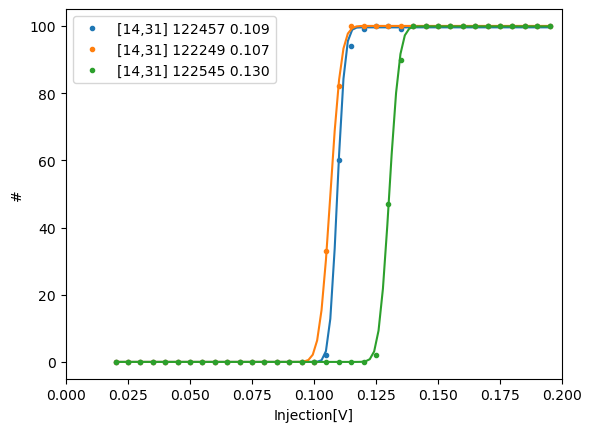

In [71]:
####################
###### IPDAC=16

list_fraw = []
list_fraw.append(os.path.join(datdir, '20240508_122457_injection_scan.h5'))  #TDAC=0
list_fraw.append(os.path.join(datdir, '20240508_122249_injection_scan.h5'))  #TDAC=1
#list_fraw.append(os.path.join(datdir, '20240508_122007_injection_scan.h5'))  #TDAC=3
list_fraw.append(os.path.join(datdir, '20240508_122545_injection_scan.h5'))  #TDAC=7
plot_data(list_fraw)

array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_121827_injection_scan.h5', 0.11114374, 4.30310065e-05, 14, 31),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_122132_injection_scan.h5', 0.11456248, 1.01007994e-04, 14, 31),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_122007_injection_scan.h5', 0.11967167, 1.70153089e-05, 14, 31),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters/20240508_121537_injection_scan.h5', 0.13061099, 4.61292329e-05, 14, 31)],
      dtype=[('fname', 'S128'), ('th', '<f4'), ('th_err', '<f4'), ('col', '<i4'), ('row', '<i4')])

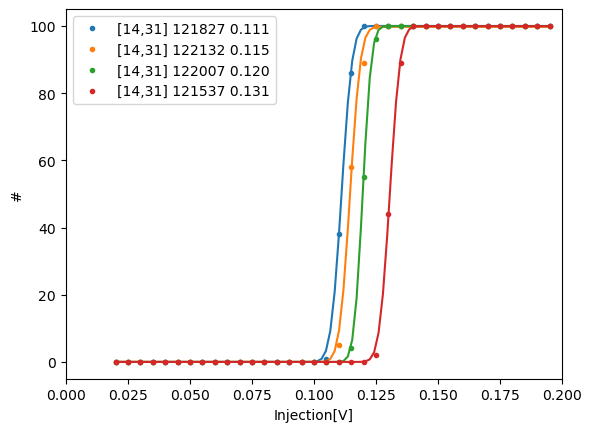

In [72]:
####################
###### IPDAC=8

list_fraw = []
list_fraw.append(os.path.join(datdir, '20240508_121827_injection_scan.h5'))  #TDAC=0
list_fraw.append(os.path.join(datdir, '20240508_122132_injection_scan.h5'))  #TDAC=1
list_fraw.append(os.path.join(datdir, '20240508_122007_injection_scan.h5'))  #TDAC=3
#list_fraw.append(os.path.join(datdir, '20240508_115950_injection_scan.h5'))  #TDAC=4
list_fraw.append(os.path.join(datdir, '20240508_121537_injection_scan.h5'))  #TDAC=7
plot_data(list_fraw)

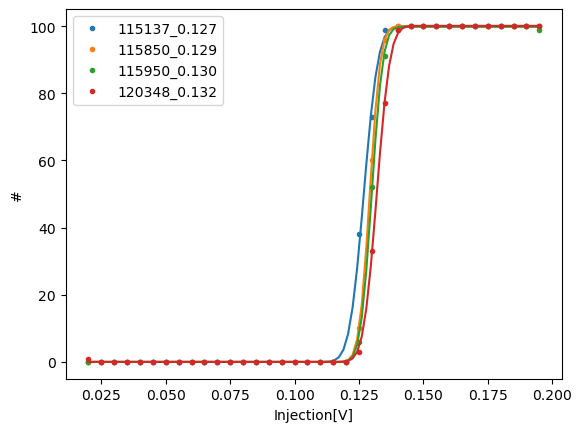

In [9]:
####################
###### IPDAC=1

list_fraw = []
list_fraw.append(os.path.join(datdir, '20240508_115137_injection_scan.h5'))  #TDAC=0
list_fraw.append(os.path.join(datdir, '20240508_115850_injection_scan.h5'))  #TDAC=1  min
list_fraw.append(os.path.join(datdir, '20240508_115950_injection_scan.h5'))  #TDAC=4
list_fraw.append(os.path.join(datdir, '20240508_120348_injection_scan.h5'))  #TDAC=7
plot_data(list_fraw)


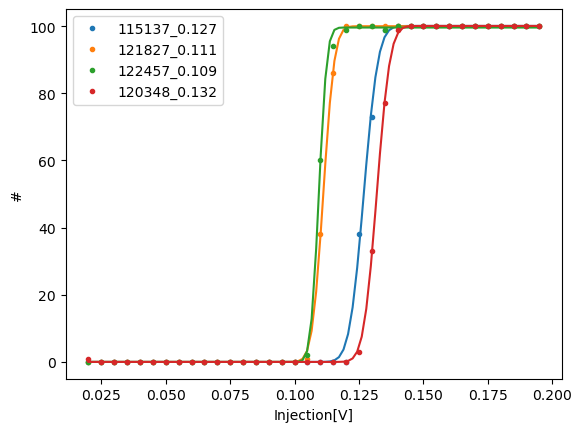

In [25]:
####################
###### IPDAC=1

list_fraw = []
list_fraw.append(os.path.join(datdir, '20240508_115137_injection_scan.h5'))  #TDAC_n=0 IPDAC1
list_fraw.append(os.path.join(datdir, '20240508_121827_injection_scan.h5'))  #TDAC_n=0 IPDAC8
list_fraw.append(os.path.join(datdir, '20240508_122457_injection_scan.h5'))  #TDAC_n=0 IPDAC16
list_fraw.append(os.path.join(datdir, '20240508_120348_injection_scan.h5'))  #TDAC_n=7 (IPDAC1)
plot_data(list_fraw)

## 9pixles

20240515_114803_injection_scan.h5
20240515_114807_injection_scan.h5
20240515_114811_injection_scan.h5
20240515_114815_injection_scan.h5
20240515_114818_injection_scan.h5
20240515_114822_injection_scan.h5
20240515_114826_injection_scan.h5
20240515_114830_injection_scan.h5
20240515_114834_injection_scan.h5


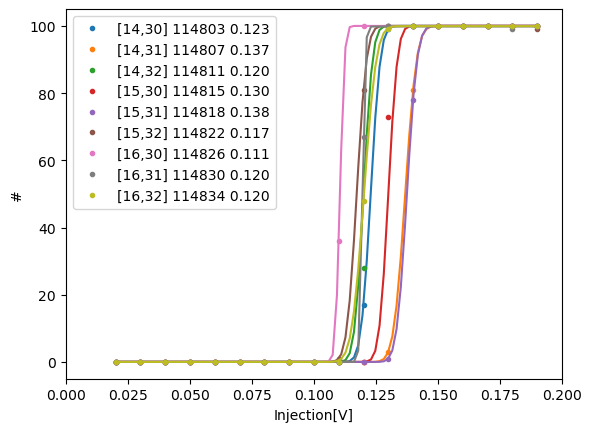

In [87]:
### TDAC7

datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac7'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret = plot_data(list_fraw)

20240515_115151_injection_scan.h5
20240515_115155_injection_scan.h5
20240515_115159_injection_scan.h5
20240515_115203_injection_scan.h5
20240515_115207_injection_scan.h5
20240515_115210_injection_scan.h5
20240515_115214_injection_scan.h5
20240515_115218_injection_scan.h5
20240515_115222_injection_scan.h5


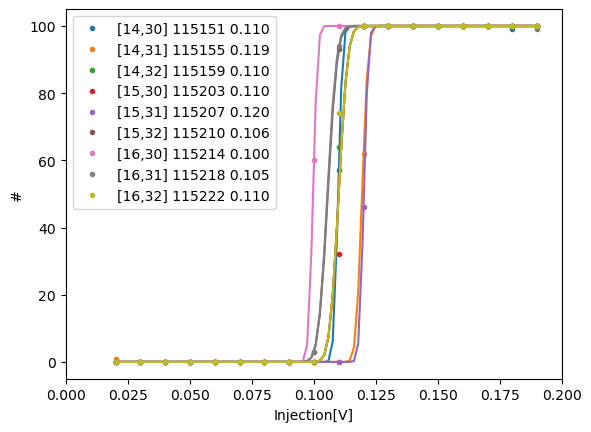

In [76]:
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret0 = plot_data(list_fraw)

array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0/20240515_115207_injection_scan.h5', 0.12014253,          inf, 15, 31),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/20240515_114818_injection_scan.h5', 0.13750798, 3.948013e-07, 15, 31)],
      dtype=[('fname', 'S128'), ('th', '<f4'), ('th_err', '<f4'), ('col', '<i4'), ('row', '<i4')])

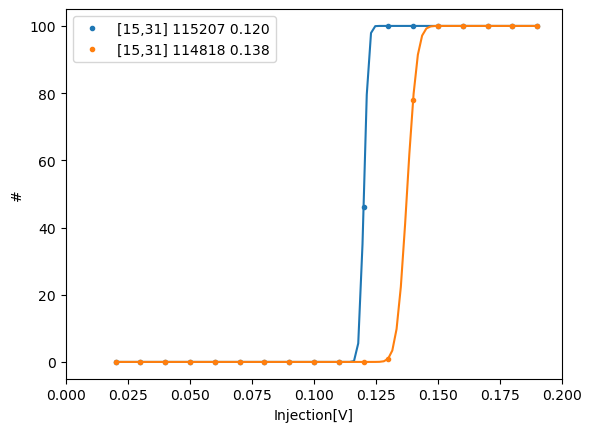

In [69]:
list_fraw = []
list_fraw.append('/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0/20240515_115207_injection_scan.h5')
list_fraw.append('/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/20240515_114818_injection_scan.h5')
plot_data(list_fraw)

array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0/20240515_115155_injection_scan.h5', 0.11941937, 6.2081397e-02, 14, 31),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/20240515_114807_injection_scan.h5', 0.13681799, 6.2829326e-07, 14, 31)],
      dtype=[('fname', 'S128'), ('th', '<f4'), ('th_err', '<f4'), ('col', '<i4'), ('row', '<i4')])

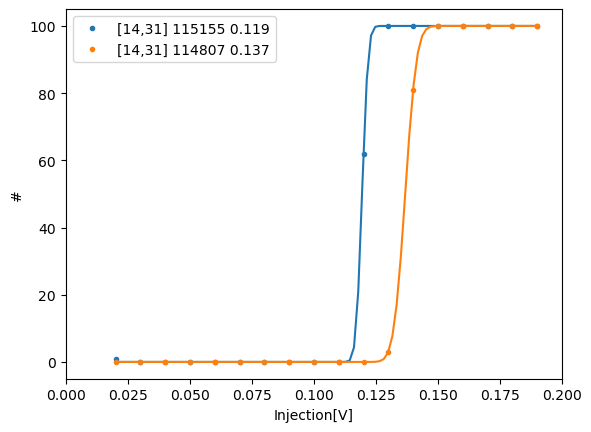

In [73]:
list_fraw = []
list_fraw.append('/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0/20240515_115155_injection_scan.h5')
list_fraw.append('/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac7/20240515_114807_injection_scan.h5')
plot_data(list_fraw)

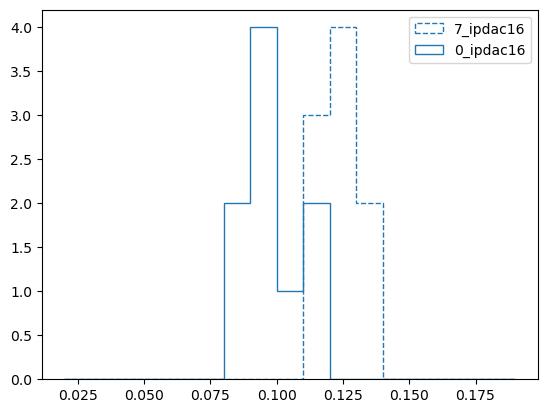

In [112]:
bins=np.arange(0.02, 0.2, 0.01)
#plt.hist(ret['th'],bins=bins , histtype='step', label='7_ipdac8', linestyle='dashed')
#plt.hist(ret0['th'], bins=bins, histtype='step', label='0_ipdac8')
plt.hist(ret16_7['th'], bins=bins, 
         histtype='step', label='7_ipdac16', linestyle='dashed', color='C0')
plt.hist(ret16_0['th'], bins=bins, 
         histtype='step', label='0_ipdac16', color='C0')
#plt.hist(ret24_0['th'], bins=bins, histtype='step', label='0_ipdac24')
#plt.hist(ret24_7_20['th'], bins=bins, 
#         histtype='step', label='7_ipdac24_comp20', linestyle='dashed', color='C1')
#plt.hist(ret24_0_20['th'], bins=bins, 
#         histtype='step', label='0_ipdac24_comp20', color='C1')

plt.legend()

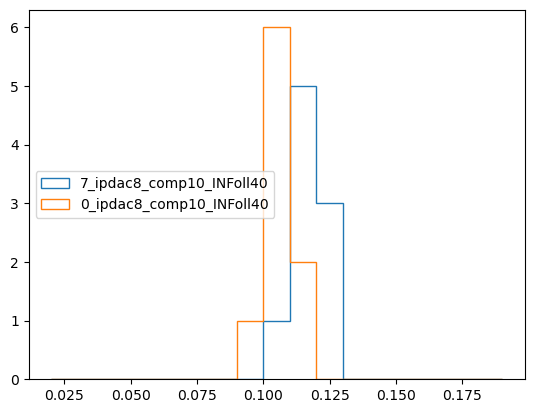

In [122]:
bins=np.arange(0.02, 0.2, 0.01)
#plt.hist(ret['th'],bins=bins , histtype='step', label='7_ipdac8_comp10', linestyle='dashed')
#plt.hist(ret0['th'], bins=bins, histtype='step', label='0_ipdac8_comp10')
#plt.hist(ret16_7['th'], bins=bins, histtype='step', label='7_ipdac16')
#plt.hist(ret16_0['th'], bins=bins, histtype='step', label='0_ipdac16')
#plt.hist(ret24_0['th'], bins=bins, histtype='step', label='0_ipdac24')
#plt.hist(ret24_0_20['th'], bins=bins, histtype='step', label='0_ipdac24_comp20')
#plt.hist(ret24_7_20['th'], bins=bins, histtype='step', label='7_ipdac24_comp20')
plt.hist(ret8_7_10_40['th'], bins=bins, histtype='step', label='7_ipdac8_comp10_INFoll40')
plt.hist(ret8_0_10_40['th'], bins=bins, histtype='step', label='0_ipdac8_comp10_INFoll40')

plt.legend()

20240515_121638_injection_scan.h5
20240515_121645_injection_scan.h5
20240515_121651_injection_scan.h5
20240515_121658_injection_scan.h5
20240515_121705_injection_scan.h5
20240515_121712_injection_scan.h5
20240515_121719_injection_scan.h5
20240515_121726_injection_scan.h5
20240515_121733_injection_scan.h5


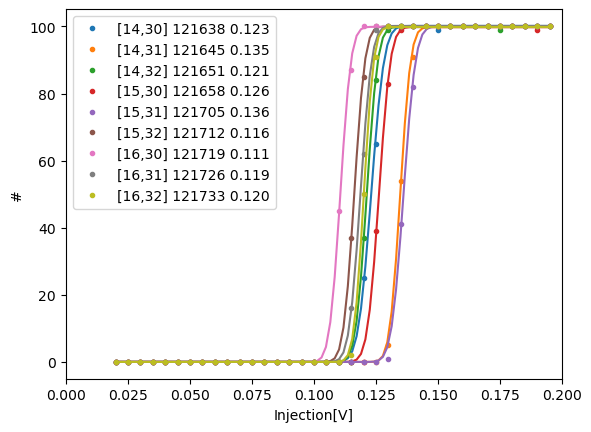

In [81]:
############
## IPDAC 16 TDAC7
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac7_ipdac16'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret16_7 = plot_data(list_fraw)

20240515_122239_injection_scan.h5
20240515_122246_injection_scan.h5
20240515_122253_injection_scan.h5
20240515_122300_injection_scan.h5
20240515_122307_injection_scan.h5
20240515_122314_injection_scan.h5
20240515_122321_injection_scan.h5
20240515_122328_injection_scan.h5
20240515_122335_injection_scan.h5


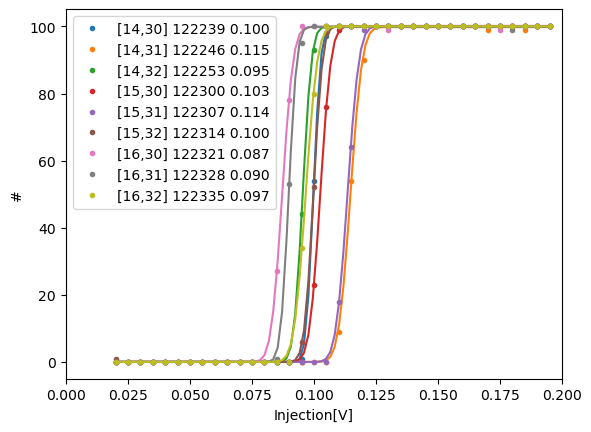

In [99]:
############
## IPDAC 16 TDAC0
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0_ipdac16'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret16_0 = plot_data(list_fraw)

20240515_122639_injection_scan.h5
20240515_122646_injection_scan.h5
20240515_122653_injection_scan.h5
20240515_122700_injection_scan.h5
20240515_122707_injection_scan.h5
20240515_122714_injection_scan.h5
20240515_122721_injection_scan.h5
20240515_122728_injection_scan.h5
20240515_122735_injection_scan.h5


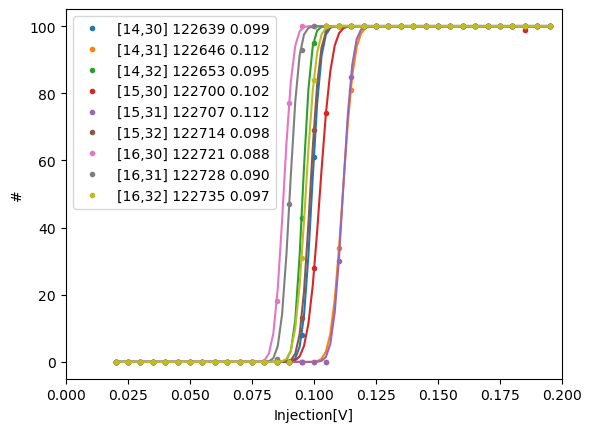

In [93]:
############
## IPDAC 24 TDAC0
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0_ipdac24'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret24_0 = plot_data(list_fraw)

20240515_123145_injection_scan.h5
20240515_123152_injection_scan.h5
20240515_123159_injection_scan.h5
20240515_123206_injection_scan.h5
20240515_123213_injection_scan.h5
20240515_123220_injection_scan.h5
20240515_123227_injection_scan.h5
20240515_123234_injection_scan.h5
20240515_123241_injection_scan.h5


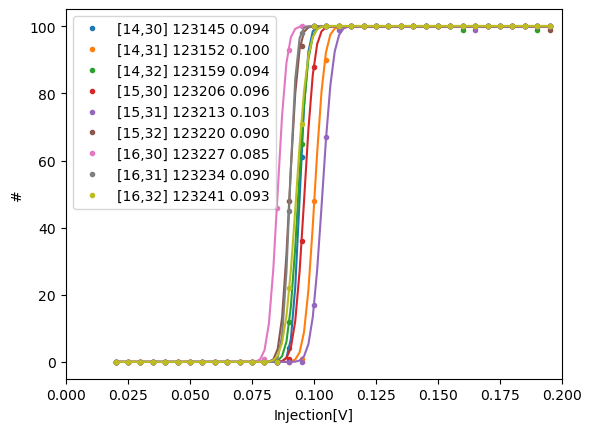

In [92]:
############
## IPDAC 24 TDAC0 VNCOMP20
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0_ipdac24_vncomp20'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret24_0_20 = plot_data(list_fraw)

20240515_123800_injection_scan.h5
20240515_123807_injection_scan.h5
20240515_123814_injection_scan.h5
20240515_123821_injection_scan.h5
20240515_123827_injection_scan.h5
20240515_123834_injection_scan.h5
20240515_123841_injection_scan.h5
20240515_123848_injection_scan.h5
20240515_123855_injection_scan.h5


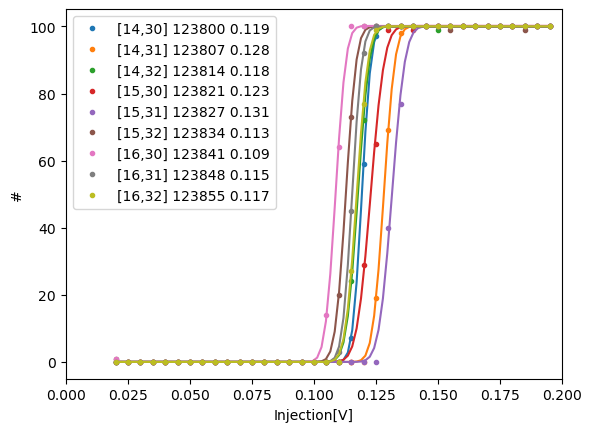

In [98]:
############
## IPDAC 24 TDAC7 VNCOMP20
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac7_ipdac24_vncomp20'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret24_7_20 = plot_data(list_fraw)

20240515_125604_injection_scan.h5
20240515_125611_injection_scan.h5
20240515_125618_injection_scan.h5
20240515_125625_injection_scan.h5
20240515_125632_injection_scan.h5
20240515_125639_injection_scan.h5
20240515_125646_injection_scan.h5
20240515_125653_injection_scan.h5
20240515_125700_injection_scan.h5


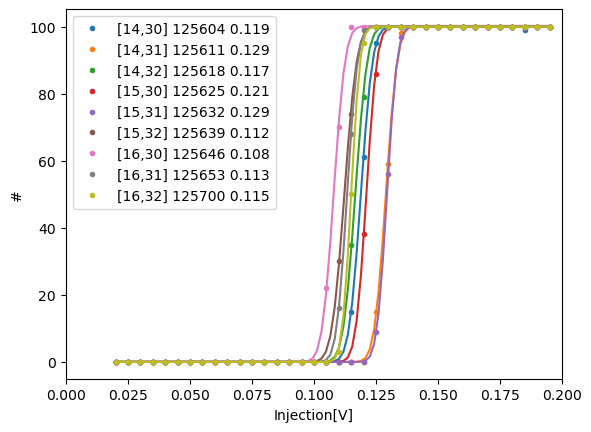

In [118]:
############
## IPDAC8 TDAC7 VNCOMP10 INFoll40
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac7_ipdac8_vncomp10_INFoll40'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret8_7_10_40 = plot_data(list_fraw)

20240515_134356_injection_scan.h5
20240515_134403_injection_scan.h5
20240515_134410_injection_scan.h5
20240515_134417_injection_scan.h5
20240515_134424_injection_scan.h5
20240515_134431_injection_scan.h5
20240515_134438_injection_scan.h5
20240515_134445_injection_scan.h5
20240515_134452_injection_scan.h5


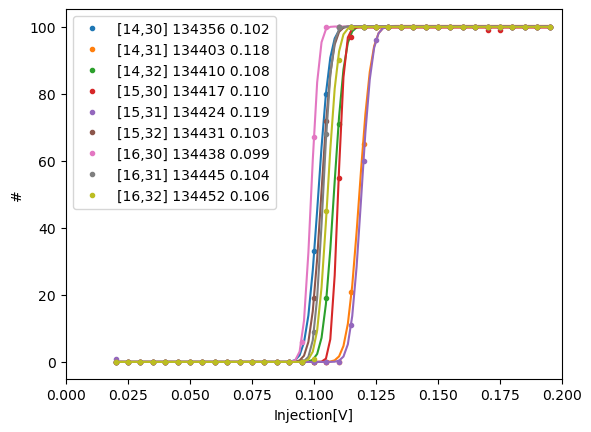

In [120]:
############
## IPDAC8 TDAC0 VNCOMP10 INFoll40
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdac0_ipdac8_vncomp10_INFoll40'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret8_0_10_40 = plot_data(list_fraw)

# scan IPDAC

20240515_135923_injection_scan.h5
20240515_135930_injection_scan.h5
20240515_135937_injection_scan.h5
20240515_135944_injection_scan.h5
20240515_135951_injection_scan.h5
20240515_135958_injection_scan.h5
20240515_140005_injection_scan.h5


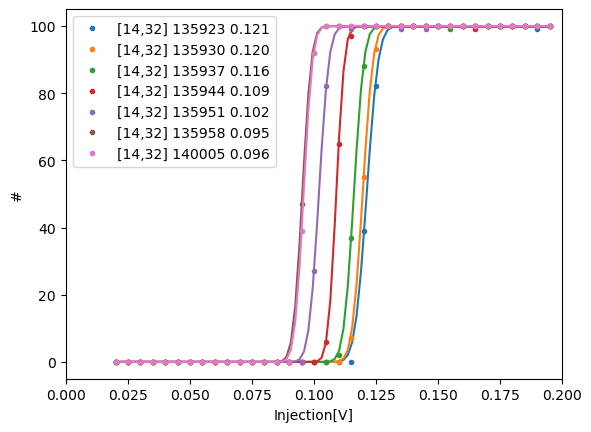

In [154]:
############
## IPDAC TDAC0 VNCOMP10 INFoll20 BLRes=4
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/ipdac/blres4'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret_ipdac = plot_data(list_fraw)

20240515_142107_injection_scan.h5
20240515_142114_injection_scan.h5
20240515_142121_injection_scan.h5
20240515_142128_injection_scan.h5
20240515_142135_injection_scan.h5
20240515_142142_injection_scan.h5
20240515_142149_injection_scan.h5
20240515_142156_injection_scan.h5


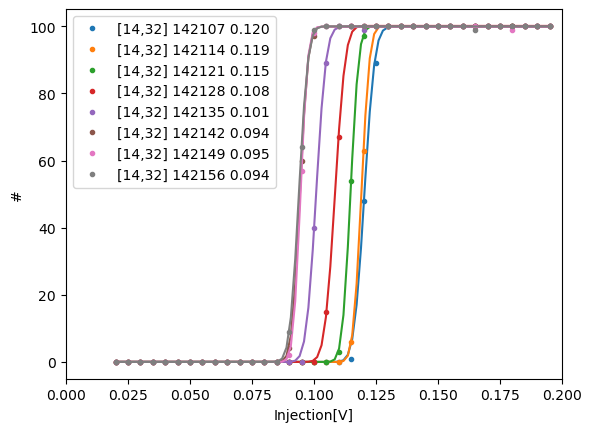

In [165]:
############
## TDAC0 VNCOMP10 INFoll20 BLRes=1
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/ipdac/blres1'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret_blres1 = plot_data(list_fraw)

20240515_143445_injection_scan.h5
20240515_143451_injection_scan.h5
20240515_143458_injection_scan.h5
20240515_143505_injection_scan.h5
20240515_143512_injection_scan.h5
20240515_143519_injection_scan.h5
20240515_143526_injection_scan.h5


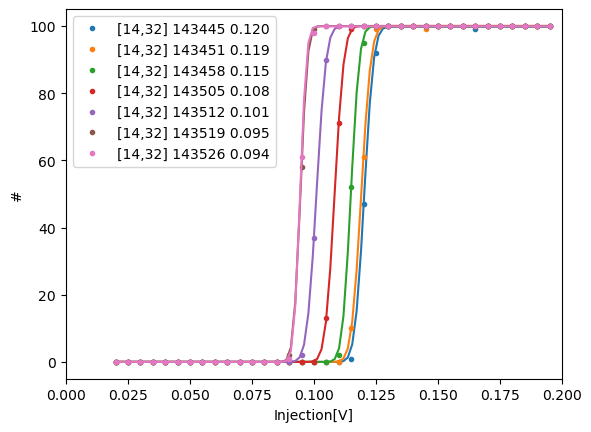

In [166]:
############
## TDAC0 VNCOMP10 INFoll20 BLRes=1 VDACBL=128
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/ipdac/blres1_bl128'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret_blres1_bl128 = plot_data(list_fraw)

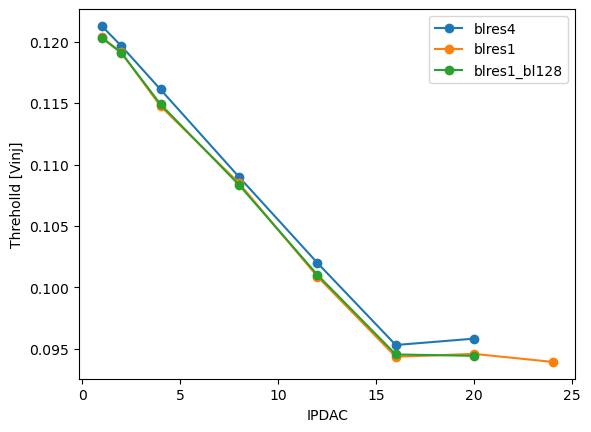

In [168]:
plt.plot(ret_ipdac['IPDAC'], ret_ipdac['th'], 'o-', label='blres4')
plt.plot(ret_blres1['IPDAC'], ret_blres1['th'], 'o-', label='blres1')
plt.plot(ret_blres1_bl128['IPDAC'], ret_blres1_bl128['th'], 'o-', label='blres1_bl128')
plt.xlabel('IPDAC')
plt.ylabel('Threholld [Vinj]')
plt.legend()

## compare BL128 and BL102

20240515_143445_injection_scan.h5
20240515_143451_injection_scan.h5
20240515_143458_injection_scan.h5
20240515_143505_injection_scan.h5
20240515_143512_injection_scan.h5
20240515_143519_injection_scan.h5
20240515_143526_injection_scan.h5


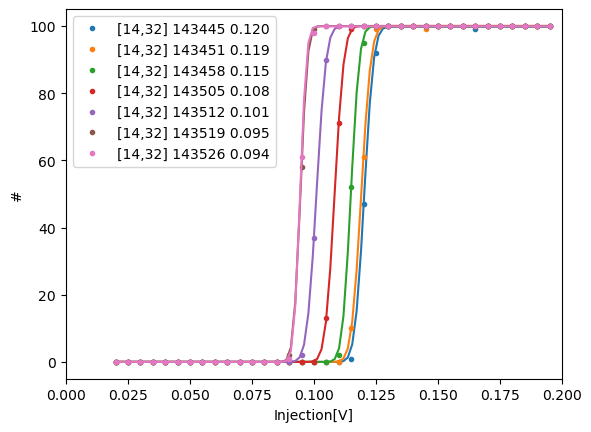

In [170]:
############
## TDAC0 VNCOMP10 INFoll20 BLRes=1 VDACBL=128 IPDAC=16
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/ipdac/blres1_bl128'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9px_blres1_bl128 = plot_data(list_fraw)

20240515_144122_injection_scan.h5
20240515_144129_injection_scan.h5
20240515_144136_injection_scan.h5
20240515_144143_injection_scan.h5
20240515_144150_injection_scan.h5
20240515_144157_injection_scan.h5
20240515_144204_injection_scan.h5
20240515_144211_injection_scan.h5
20240515_144218_injection_scan.h5


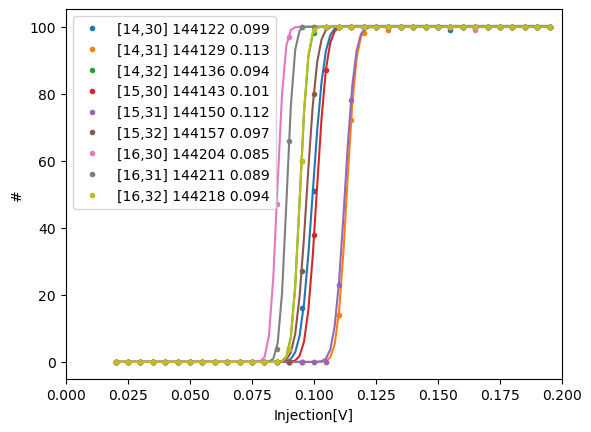

In [172]:
############
## TDAC0 VNCOMP10 INFoll20 BLRes=1 VDACBL=102 IPDAC=16 TH=th+26
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl102'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9px_blres1_bl102 = plot_data(list_fraw)

20240515_144759_injection_scan.h5
20240515_144806_injection_scan.h5
20240515_144813_injection_scan.h5
20240515_144820_injection_scan.h5
20240515_144827_injection_scan.h5
20240515_144834_injection_scan.h5
20240515_144841_injection_scan.h5
20240515_144848_injection_scan.h5
20240515_144855_injection_scan.h5


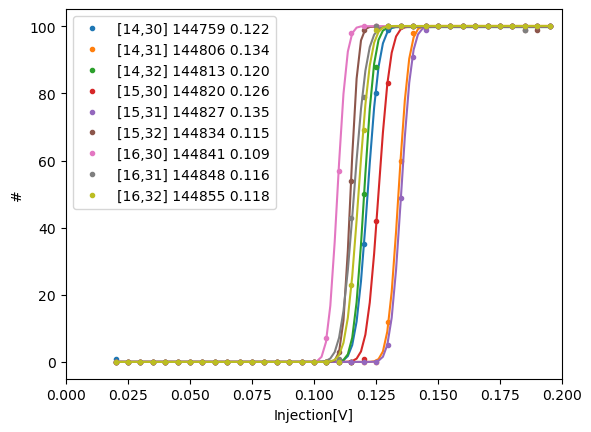

In [184]:
############
## TDAC7 VNCOMP10 INFoll20 BLRes=1 VDACBL=128 IPDAC=16 TH=th+26
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl128_tdac7'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9px7_blres1_bl128 = plot_data(list_fraw)

In [175]:
ret9px7_blres1_bl128

array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl128_tdac7/20240515_144759_injection_scan.h5', 0.12164278, 6.9071117e-05, 14, 30, 16),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl128_tdac7/20240515_144806_injection_scan.h5', 0.13408826, 3.0356630e-05, 14, 31, 16),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl128_tdac7/20240515_144813_injection_scan.h5', 0.12024627, 1.0562075e-04, 14, 32, 16),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl128_tdac7/20240515_144820_injection_scan.h5', 0.1260214 , 8.6961394e-05, 15, 30, 16),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl128_tdac7/20240515_144827_injection_scan.h5', 0.13515441, 3.1036576e-05, 15, 31, 16),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/blres1_bl128_tdac7/20240515_144834_injection_scan.h5', 0.11474401, 1.6953727e-05,

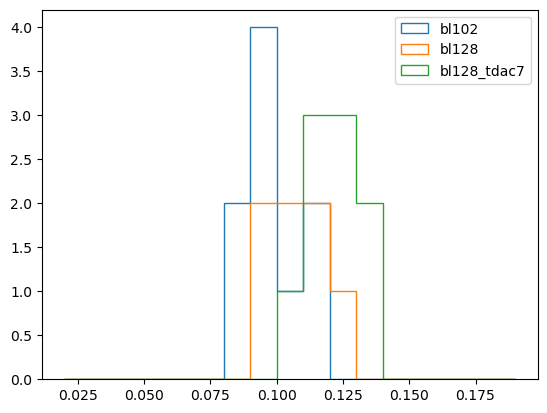

In [176]:
plt.hist(ret9px_blres1_bl102['th'], bins=bins, histtype='step', 
         label='bl102')
plt.hist(ret9px_blres1_bl128['th'], bins=bins, histtype='step', 
         label='bl128')
plt.hist(ret9px7_blres1_bl128['th'], bins=bins, histtype='step', 
         label='bl128_tdac7')
plt.legend()

20240515_155620_injection_scan.h5
20240515_155628_injection_scan.h5
20240515_155635_injection_scan.h5
20240515_155642_injection_scan.h5
20240515_155649_injection_scan.h5
20240515_155656_injection_scan.h5
20240515_155703_injection_scan.h5
20240515_155710_injection_scan.h5
20240515_155718_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155620_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155628_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155635_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155642_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155649_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast/20240515_155656_injection_scan.h5
ERROR!!!!!

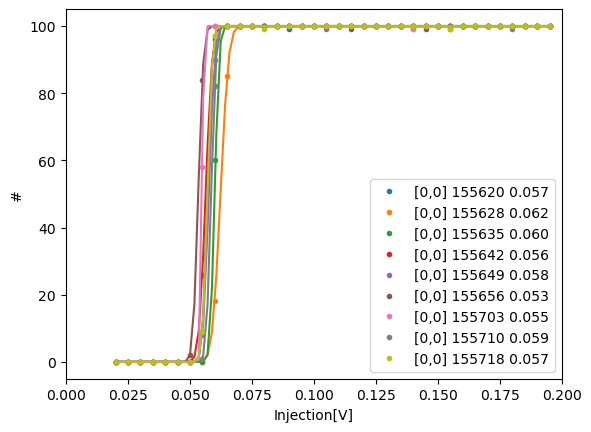

In [200]:
## TDAC7 IPDAC16 VDACTh150 IBLRes1 IBL128 fast
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9_fast = plot_data(list_fraw)

20240515_160404_injection_scan.h5
20240515_160412_injection_scan.h5
20240515_160419_injection_scan.h5
20240515_160426_injection_scan.h5
20240515_160433_injection_scan.h5
20240515_160440_injection_scan.h5
20240515_160448_injection_scan.h5
20240515_160455_injection_scan.h5
20240515_160502_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast_tdac0/20240515_160404_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast_tdac0/20240515_160412_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast_tdac0/20240515_160419_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast_tdac0/20240515_160426_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast_tdac0/20240515_160433_injection_scan.h5
ERROR!!!!! /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast_tdac0/20240515

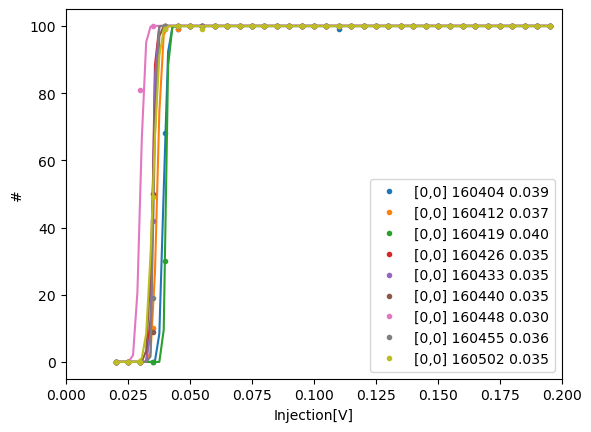

In [205]:
## TDAC0 IPDAC16 VDACTh150 IBLRes1 IBL128 fast
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/fast_tdac0'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9_fast_tdac0 = plot_data(list_fraw)

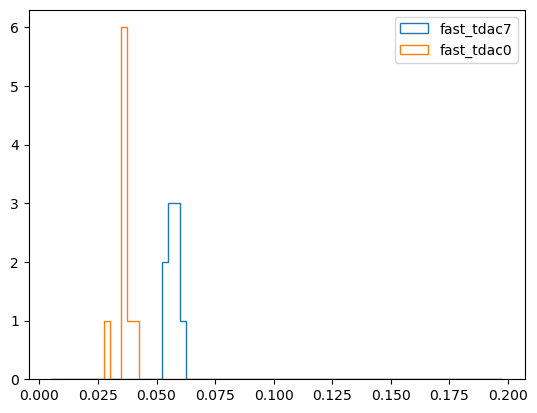

In [208]:
bins=np.arange(0.005, 0.2, 0.0025)
plt.hist(ret9_fast['th'], bins=bins, histtype='step', label='fast_tdac7')
plt.hist(ret9_fast_tdac0['th'], bins=bins, histtype='step', label='fast_tdac0')

plt.legend()

20240515_162012_injection_scan.h5
20240515_162039_injection_scan.h5
20240515_162046_injection_scan.h5
20240515_162053_injection_scan.h5
20240515_162100_injection_scan.h5
20240515_162107_injection_scan.h5
20240515_162114_injection_scan.h5
20240515_162121_injection_scan.h5
20240515_162128_injection_scan.h5
20240515_162135_injection_scan.h5


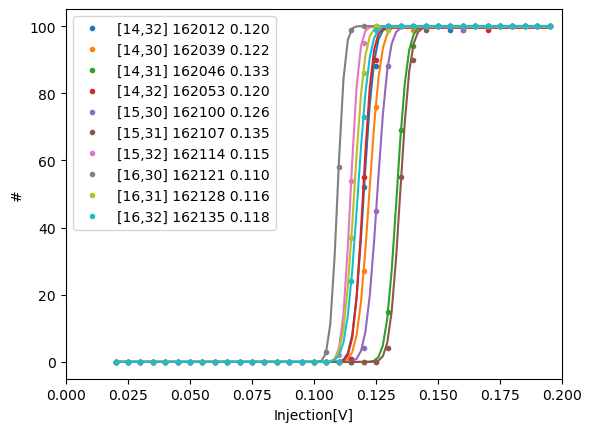

In [212]:
## TDAC7 IPDAC16 VDACTh150 IBLRes1 IBL128 slow
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/slow_tdac7'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9_slow_tdac7 = plot_data(list_fraw)

20240515_162428_injection_scan.h5
20240515_162435_injection_scan.h5
20240515_162442_injection_scan.h5
20240515_162449_injection_scan.h5
20240515_162456_injection_scan.h5
20240515_162503_injection_scan.h5
20240515_162510_injection_scan.h5
20240515_162517_injection_scan.h5
20240515_162524_injection_scan.h5


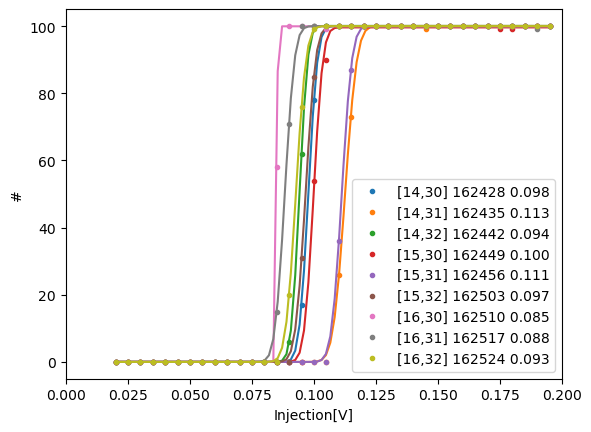

In [213]:
## TDAC0 IPDAC16 VDACTh150 IBLRes1 IBL128 slow
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/slow_tdac0'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9_slow_tdac0 = plot_data(list_fraw)

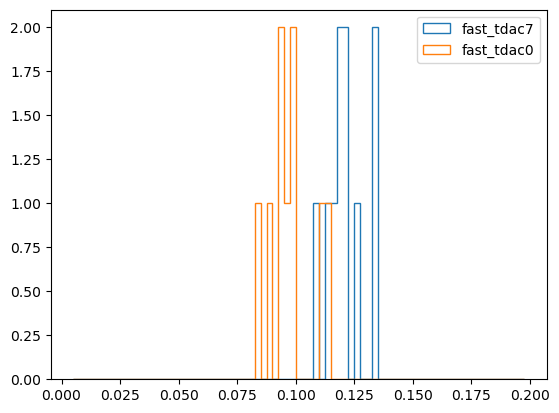

In [215]:
bins=np.arange(0.005, 0.2, 0.0025)
plt.hist(ret9_slow_tdac7['th'], bins=bins, histtype='step', label='fast_tdac7')
plt.hist(ret9_slow_tdac0['th'], bins=bins, histtype='step', label='fast_tdac0')

plt.legend()

20240515_163033_injection_scan.h5
20240515_163040_injection_scan.h5
20240515_163047_injection_scan.h5
20240515_163054_injection_scan.h5
20240515_163101_injection_scan.h5
20240515_163108_injection_scan.h5
20240515_163115_injection_scan.h5
20240515_163122_injection_scan.h5
20240515_163129_injection_scan.h5


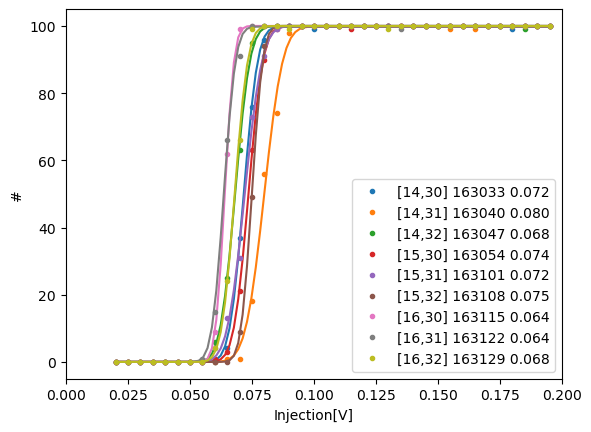

In [216]:
## TDAC0 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/slow_tdac0_vssa12'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9_slow_tdac0_vssa12 = plot_data(list_fraw)

20240515_163329_injection_scan.h5
20240515_163336_injection_scan.h5
20240515_163343_injection_scan.h5
20240515_163350_injection_scan.h5
20240515_163357_injection_scan.h5
20240515_163404_injection_scan.h5
20240515_163411_injection_scan.h5
20240515_163418_injection_scan.h5
20240515_163425_injection_scan.h5


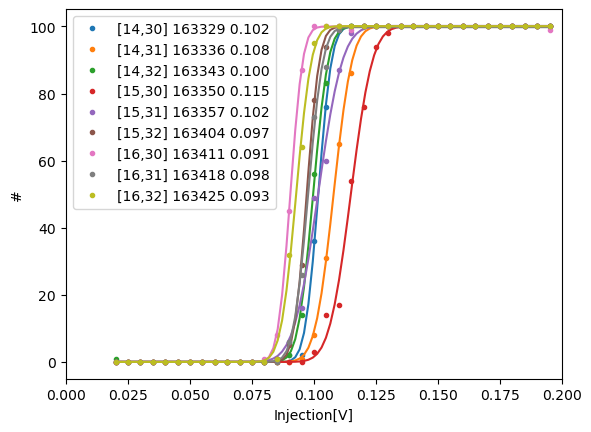

In [217]:
## TDAC7 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/slow_tdac7_vssa12'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret9_slow_tdac7_vssa12 = plot_data(list_fraw)

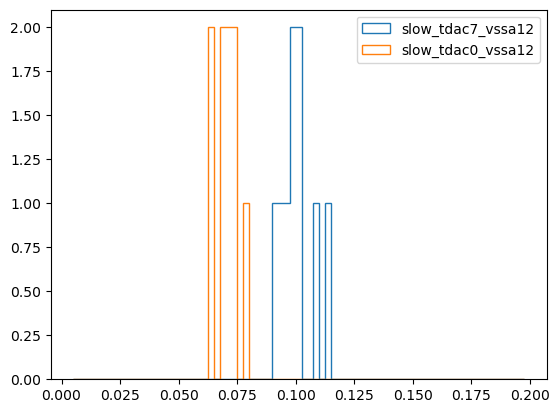

In [218]:
bins=np.arange(0.005, 0.2, 0.0025)
plt.hist(ret9_slow_tdac7_vssa12['th'], bins=bins, histtype='step', label='slow_tdac7_vssa12')
plt.hist(ret9_slow_tdac0_vssa12['th'], bins=bins, histtype='step', label='slow_tdac0_vssa12')

plt.legend()

##  Matrix

In [253]:
import time
## TDAC7 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V   Matrix!!!
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac7'
list_fraw = []
dtype = [('fname', 'S128'),('th','f'),
        ('th_err','f'),('col','i'),
        ('row','i'), 
                            #('IPDAC', 'i')
        ]
for fname in np.sort(os.listdir(datdir)):
    if fname[-7:] == 'scan.h5':
        #print(fname)
        list_fraw.append(os.path.join(datdir, fname))
t0 = time.time()
ret=np.empty(len(list_fraw), dtype=dtype)
for i, fraw in enumerate(list_fraw):
    ret[i] = plot_data_png([fraw])
    if i%100==0:
        print('time for calculation ({0}/{1} {2:.2f}s'.format(
                                             i, len(list_fraw),time.time()-t0
                                            )
             

#ret_slow_tdac7= plot_data(list_fraw)

0.05278277397155762
7.59349513053894
13.095763921737671
18.404247045516968
23.741528272628784
29.21994638442993
34.73451232910156
40.292235136032104
45.93107604980469
50.69157910346985
56.15070343017578
60.875232458114624
66.60670208930969
71.39408087730408
77.18569135665894
82.02920055389404
86.89990282058716
92.67781043052673


In [298]:
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac7'
#os.makedirs(os.path.join(datdir,'results'))
np.save(os.path.join(os.path.join(datdir,'results'), 'th_tdac7.npy'), ret)

In [275]:
import time
## TDAC0 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V   Matrix!!!
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac0'
list_fraw = []
dtype = [('fname', 'S128'),('th','f'),
        ('th_err','f'),('col','i'),
        ('row','i'), 
                            #('IPDAC', 'i')
        ]
for fname in np.sort(os.listdir(datdir)):
    if fname[-7:] == 'scan.h5':
        #print(fname)
        list_fraw.append(os.path.join(datdir, fname))
t0 = time.time()
ret0=np.empty(len(list_fraw), dtype=dtype)    ##should change ret
for i, fraw in enumerate(list_fraw):
    ret0[i] = plot_data_png([fraw])           ##should change ret
    if i%100==0:
        print('time for calculation ({0}/{1}) {2:.2f}s'.format(
                                             i, len(list_fraw),time.time()-t0
                                            )
             )

time for calculation (0/1797 0.06s
time for calculation (100/1797 7.90s
time for calculation (200/1797 13.05s
time for calculation (300/1797 18.26s
time for calculation (400/1797 23.59s
time for calculation (500/1797 28.95s
time for calculation (600/1797 34.38s
time for calculation (700/1797 39.85s
time for calculation (800/1797 45.40s
time for calculation (900/1797 50.23s
time for calculation (1000/1797 55.85s
time for calculation (1100/1797 60.69s
time for calculation (1200/1797 66.55s
time for calculation (1300/1797 71.43s
time for calculation (1400/1797 76.33s
time for calculation (1500/1797 82.37s
time for calculation (1600/1797 87.39s
time for calculation (1700/1797 93.47s


In [300]:
import time
## TDAC1 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V   Matrix!!!
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac1'
list_fraw = []
dtype = [('fname', 'S128'),('th','f'),
        ('th_err','f'),('col','i'),
        ('row','i'), 
                            #('IPDAC', 'i')
        ]
for fname in np.sort(os.listdir(datdir)):
    if fname[-7:] == 'scan.h5':
        #print(fname)
        list_fraw.append(os.path.join(datdir, fname))
t0 = time.time()
ret1=np.empty(len(list_fraw), dtype=dtype)    ##should change ret
for i, fraw in enumerate(list_fraw):
    ret1[i] = plot_data_png([fraw])           ##should change ret
    if i%100==0:
        print('time for calculation ({0}/{1}) {2:.2f}s'.format(
                                             i, len(list_fraw),time.time()-t0
                                            )
             )

time for calculation (0/1798) 0.05s
time for calculation (100/1798) 4.89s
time for calculation (200/1798) 12.98s
time for calculation (300/1798) 18.22s
time for calculation (400/1798) 23.51s
time for calculation (500/1798) 28.83s
time for calculation (600/1798) 34.29s
time for calculation (700/1798) 39.85s
time for calculation (800/1798) 44.76s
time for calculation (900/1798) 50.41s
time for calculation (1000/1798) 56.11s
time for calculation (1100/1798) 61.10s
time for calculation (1200/1798) 67.10s
time for calculation (1300/1798) 72.07s
time for calculation (1400/1798) 77.09s
time for calculation (1500/1798) 83.11s
time for calculation (1600/1798) 87.94s
time for calculation (1700/1798) 94.08s


In [299]:
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac0'
os.makedirs(os.path.join(datdir,'results'))
np.save(os.path.join(os.path.join(datdir,'results'), 'th_tdac0.npy'), ret0)

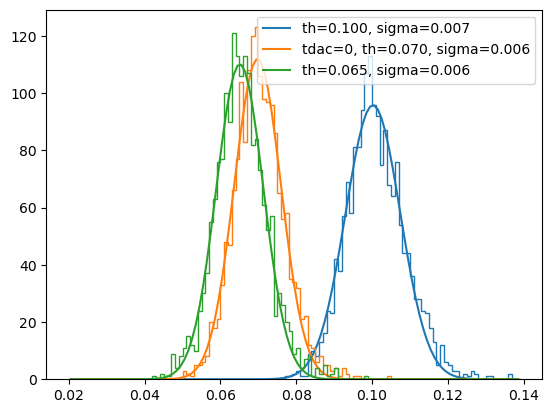

In [321]:
bins = np.arange(0.02,0.14,0.001)
x = (bins[:-1]+bins[1:])/2.0

#####
tmp = ret[ret['row']>0]
hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C0');
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C0')
####
tmp = ret0[ret0['row']>0]

hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C1')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="tdac={0:.0f}, th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C1')



####
tmp = ret1[ret1['row']>0]

hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C2')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C2')


plt.legend()

In [290]:
tmp[['col','row','th']][tmp['th']>0.09]

array([( 0, 56, 0.09221702), ( 5, 34, 0.09053348), (14, 53, 0.09576622),
       (17, 36, 0.09350025), (19, 54, 0.09269083), (19, 55, 0.0917877 ),
       (21, 48, 0.09035875), (25,  1, 0.0924167 ), (26,  5, 0.09026131),
       (26, 39, 0.09095348), (27,  7, 0.10467208), (27, 38, 0.09381484),
       (27, 56, 0.09672976), (28,  8, 0.09219601)],
      dtype={'names': ['col', 'row', 'th'], 'formats': ['<i4', '<i4', '<f4'], 'offsets': [136, 140, 128], 'itemsize': 144})

ValueError: not enough values to unpack (expected 2, got 1)

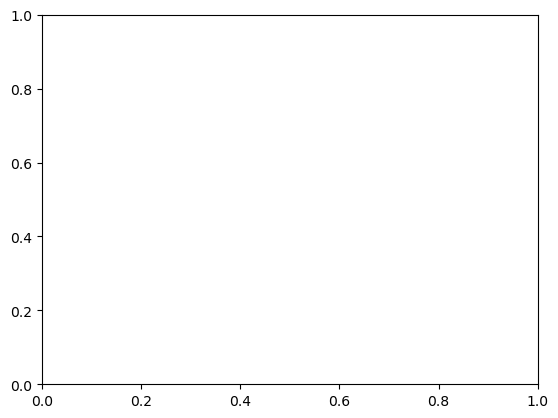

In [280]:
img =np.

In [282]:
Z = np.random.rand(6, 10)
len(Z)

6

(0.0, 0.7)

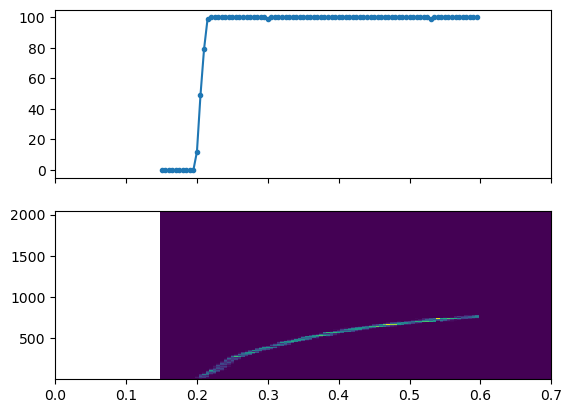

In [298]:
## get data from hit file (event_data)
#fname = os.path.basename(fraw)
fraw = os.path.join(datdir,'20240315_123118_injection_scan.h5')
fhit = fraw[:-7] + 'hit.h5'

with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator1
dat1 = dat[dat['comp']==1]
nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(param['inj'], nhit1, '.-')

xbins = np.arange(param['inj'][0]-(param['inj'][-1]-param['inj'][-2])/2, 
                  param['inj'][-1]+(param['inj'][-1]+param['inj'][-2])/2,
                  param['inj'][-1]-param['inj'][-2])
                  

ax[1].hist2d(param[dat1['event_number']]['inj'], dat1['tot'], 
           bins=[xbins, np.arange(1, 2048,10)]);
ax[0].set_xlim(0,0.7)

(0.0, 0.7)

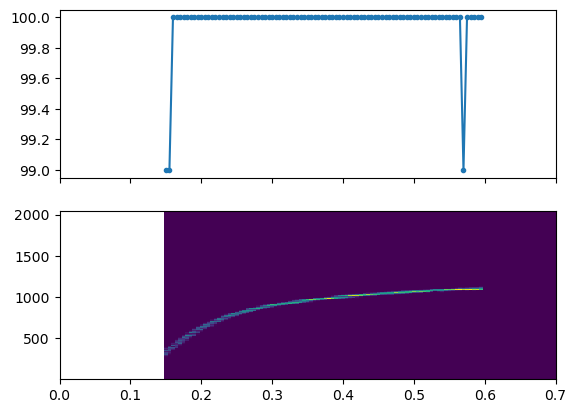

In [299]:
fraw = os.path.join(datdir,'20240315_123507_injection_scan.h5')
fhit = fraw[:-7] + 'hit.h5'

with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator1
dat1 = dat[dat['comp']==1]
nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(param['inj'], nhit1, '.-')

xbins = np.arange(param['inj'][0]-(param['inj'][-1]-param['inj'][-2])/2, 
                  param['inj'][-1]+(param['inj'][-1]+param['inj'][-2])/2,
                  param['inj'][-1]-param['inj'][-2])
                  

ax[1].hist2d(param[dat1['event_number']]['inj'], dat1['tot'], 
           bins=[xbins, np.arange(1, 2048,10)]);
ax[0].set_xlim(0,0.7)

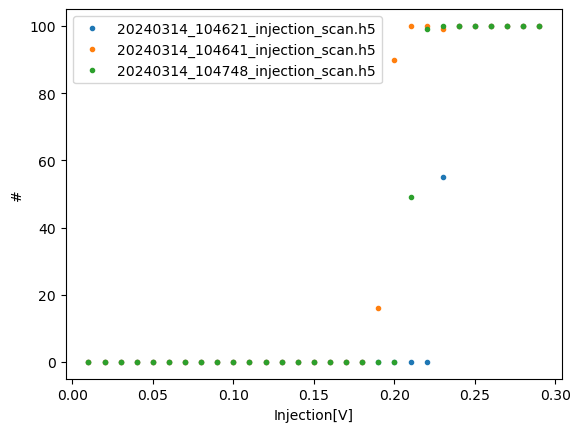

In [144]:
list_fraw = []
list_fraw.append(os.path.join(datdir, '20240314_104621_injection_scan.h5'))  # TDAC= 7 IPDAC=8 VComp2=10
list_fraw.append(os.path.join(datdir, '20240314_104641_injection_scan.h5'))  # TDAC= 0 IPDAC=8 VComp2=10
list_fraw.append(os.path.join(datdir, '20240314_104748_injection_scan.h5'))  # TDAC= 3 IPDAC=12 VComp2=16

#list_fraw.append(os.path.join(datdir, '20240308_125247_injection_scan.h5'))  # TDAC=7 IPDAC=12 VComp2=32
#list_fraw.append(os.path.join(datdir, '20240308_123703_injection_scan.h5'))  # TDAC=7 IPDAC=4
#list_fraw.append(os.path.join(datdir, '20240308_124602_injection_scan.h5'))  # TDAC=3 IPDAC=4

plot_data(list_fraw)